# Mounting data
On your drive go to `shared folders` and find the shared project folder `599 Project`.

Right click and click **add to shortcut**. Then add it to MyDrive as the __very first path__. Otherwise you may need to modify next cell the hardcoded paths.

In [ ]:
from google.colab import drive

# Mount the folder
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from_handwritten_text_csv_path = "/content/drive/MyDrive/599 Project/custom-dataset-script/handwritten-text-images-labels.csv"
from_handwritten_text_zip_path = "/content/drive/MyDrive/599 Project/custom-dataset-script/handwritten-text-images-database.zip"
import os
if os.path.exists(from_handwritten_text_csv_path): print("Found handwritten csv data")
if os.path.exists(from_handwritten_text_zip_path): print("Found handwritten zip data")

Found handwritten csv data
Found handwritten zip data


In [ ]:
import shutil
handwritten_text_csv_path = shutil.copy(from_handwritten_text_csv_path, ".")
handwritten_text_zip_path = shutil.copy(from_handwritten_text_zip_path, ".")
if os.path.exists("./handwritten_database"): shutil.rmtree("./handwritten_database")
# extract zip file
import zipfile
def extract_zip_to(src, dst):
  with zipfile.ZipFile(src, 'r') as zip_ref:
      zip_ref.extractall(dst)
  return dst
extract_zip_to(handwritten_text_zip_path, "./handwritten_database")
# move nested folders to parent and remove nonsense
for f in os.listdir("./handwritten_database/database"):
  shutil.move(os.path.join("./handwritten_database/database", f), "./handwritten_database")
shutil.rmtree("./handwritten_database/database")
shutil.rmtree("./handwritten_database/__MACOSX")

In [ ]:
if os.path.exists("./sample images"): shutil.rmtree("./sample images")
shutil.copytree("/content/drive/MyDrive/599 Project/custom-dataset-script/sample images","./sample images")
extract_zip_to("/content/drive/MyDrive/599 Project/custom-dataset-script/fonts/roboto.zip", "./fonts")


'./fonts'

# Create Custom Dataset

## TextDataset

In [ ]:
import pandas as pd

pd.DataFrame()
# TODO: generate a folder for printed text images: stay consistent in teh approach of embedding images


""


In [ ]:
from PIL import Image
import pandas as pd
import os
class TextDataset:
  def __init__(self, root, csvpath, returnpathonly=False,csvheader=0):
    assert isinstance(root, str)
    assert isinstance(csvpath, str)

    self.paths = []
    self.labels = []
    """
      root: parent path that contains IMAGES only and each image has a text
      csvpath: path of csv that contains info of text for every image
    """
    self.return_mode = returnpathonly
    
    img_files = [img_file
      for img_file in os.listdir(root) 
      if os.path.isfile(os.path.join(root, img_file))
      if ".csv" != img_file[-4:]]

    # read csv file to generate labels
    assert os.path.exists(csvpath) and os.path.isfile(csvpath)
    df = pd.read_csv(csvpath, header=csvheader, names=[0,1], keep_default_na=False) # keep_default_na prevent empty cells to be nan in pandas df
    assert len(df.columns) == 2
    label_map = dict(zip(df[0], df[1]))

    for img_file in img_files: # use label_map dictionary to speed up
      if img_file in label_map:
        self.paths.append(os.path.join(root, img_file))
        label = label_map[img_file]
        self.labels.append(label)


    assert len(self.paths) == len(self.labels)

  def setpathonly(self, mode=True):
    self.return_mode = mode

  def __len__(self):
    return len(self.paths)
  def __getitem__(self, i):
    if self.return_mode == False:
      # return image and label
      # read i-th image
      img = Image.open(self.paths[i])
      return img, self.labels[i]
    else: return self.paths[i], self.labels[i]
  

In [ ]:
# quick test
a = TextDataset("handwritten_database/en_train_filtered", "handwritten_database/en_train_filtered/labels.csv", True)
print(len(a))
a[0],a[1]

19999


(('handwritten_database/en_train_filtered/b01-027-06-05.png', 'cruel'),
 ('handwritten_database/en_train_filtered/a01-038x-05-06.png', 'Greenfield'))

## CustomDataset

In [ ]:
import random, os, cv2
from PIL import Image
class CustomDataset:
  def __init__(self, root: str, printed: TextDataset, handwritten: TextDataset, labelmode = "classifier", transform=None, random=False):
    """
      root: path of dataset containing images to embed text onto
      printed: textdataset of printed images
      handwritten: textdataset of handwritten images
      tranform: any function to be applied when __getitem__
      labelmode:
        - "texttype": labels are "None", "P", "H", "PH"
            - specifies what type of embedding text has
            - P is for printed and H is for handwritten. None implies
              image has no embedding
        - "text": label will be a sequence of bounding box followed by text contained
            format: a b c d "string" e f g h "string"
      random:
        - if True then generates a possible random text embedding of image and
          will be different every time a new image is requested with __getitem__
        - if True, dataset is NOT EXPORTABLE.
        - if True, generated images on the fly and thus efficient to initialize dataset

    """
    assert isinstance(printed, TextDataset)
    assert isinstance(handwritten, TextDataset)
    assert isinstance(root, str)
    assert isinstance(labelmode, str)
    assert labelmode in ["text", "texttype"]
    assert isinstance(random, bool)
    self.transform = transform
    self.random = random
    self.printed_text_dataset = printed
    self.handwritten_text_dataset = handwritten
    self.labelmode = labelmode

    self.printed_text_dataset.setpathonly() # will return image path instead with getitem
    self.handwritten_text_dataset.setpathonly()
    
    self.original_image_paths = [os.path.join(root, path) 
      for path in os.listdir(root) 
      if os.path.isfile(os.path.join(root, path))]
    print(self.original_image_paths)

    if self.random is False:
      self.initialize_embeddings()

  def generate_embedding(self, base_path, embed_paths, xys):
    # Open the base image and the image to embed
    base_image = Image.open(base_path)
    assert len(embed_paths) == len(xys)
    for embed_path, (x,y) in zip(embed_paths, xys):
      embed_image = Image.open(embed_path)

      """
        this one seems to be simpler and works just fine
      """
      alpha_mask = embed_image.split()[-1]
      # Convert the alpha mask to a binary mask
      # white background should be removed so > 230 works well
      binary_mask = alpha_mask.point(lambda x: 0 if x > 230 else 255, '1')

      # paste embed onto base using mask to minimize background of embed being pasted
      base_image.paste(embed_image, (x, y), binary_mask)

      """
        need to check if PIL.alpha_composite does the same task in a better way or not
        it seems to make embedded image invisible at the moment
      base_image = base_image.convert("RGBA")
      embed_image = embed_image.convert("RGBA")
      matching_size_embed_image = Image.new("RGBA", base_image.size, (255,255,255,0)) # transparent background
      alpha_mask = embed_image.split()[-1]
      binary_mask = alpha_mask.point(lambda x: 0 if x > 230 else 255, '1')
      matching_size_embed_image.paste(embed_image, (x,y), binary_mask)
      base_image = Image.alpha_composite(base_image, matching_size_embed_image)
      """

    return base_image
  
  def get_label(self, embedded_text_type="None", bounding_boxes=[], texts=[]):
    label = None
    if self.labelmode == "texttype": label = embedded_text_type
    elif self.labelmode == "text":
      assert len(bounding_boxes) == len(texts)
      bounding_boxes = [list(map(str, box)) for box in bounding_boxes]
      bounding_boxes = [" ".join(box) for box in bounding_boxes] # top left corner x y and dimension of rectangle
      all_embeddings = [f"{box} {text}" for box, text in zip(bounding_boxes, texts)]
      label = " %% ".join(all_embeddings)
    
    assert label is not None
    return label

  def get_random_embedding_by_type(self, img_path: str, textdataset: TextDataset):
    bounding_boxes = []
    texts = []
    top_lefts = []
    text_img_paths = []
    
    width, height = Image.open(img_path).size
    i = random.randrange(len(textdataset))
    text_img_path, text = textdataset[i]
    text_width, text_height = Image.open(text_img_path).size
    if text_width < width//2 and text_height < height // 2:
      x,y = random.randrange(width-text_width), random.randrange(height-text_height)

      # NOTE: bounding boxes are axis-aligned
      bounding_boxes = [[x, y, text_width, text_height]]
      texts = [text]
      text_img_paths = [text_img_path]
      top_lefts = [(x,y)]

    return bounding_boxes, texts, top_lefts, text_img_paths

  def get_combined_random_embedding(self, img_path):
    width, height = Image.open(img_path).size
    while True: # assume width and height are large enough to embed a text in image
      # pick at least 1 printed text
      i = random.randrange(len(self.printed_text_dataset))
      tipi, ti = self.printed_text_dataset[i]
      twi, thi = Image.open(tipi).size
      # pick at least 1 handwritten text
      j = random.randrange(len(self.handwritten_text_dataset))
      tipj, tj = self.handwritten_text_dataset[j]
      twj, thj = Image.open(tipj).size

      if twi < width//2 and thi < height // 2 and twj < width // 2 and thj < height // 2:
        if twi + twj < width//2 or thi + thj < height//2:
          xi, yi = random.randrange(width-twi), random.randrange(height-thi)
          xj, yj = random.randrange(width-twj), random.randrange(height-thj)
          # ensure no overlap
          x1, y1, w1, h1 = xi, yi, twi, thi
          x2, y2, w2, h2 = xj, yj, twj, thj
          condition1 = x1 + w1 < x2 or x1 > x2 + w2
          condition2 = y1 + h1 < y2 or y1 > y2 + h2
          does_not_overlap = condition1 or condition2
          if does_not_overlap:
            bounding_boxes = [[x1, y1, w1, h1],[x2, y2, w2, h2]]
            texts = [ti, tj]
            text_img_paths = [tipi, tipj]
            top_lefts = [(x1,y1),(x2,y2)]
            return bounding_boxes, texts, top_lefts, text_img_paths
            break
  def get_any_random_possible_embedding(self, img_path):
    choice = random.randrange(4)
    encoder = {0: "None", 1: "P", 2: "H", 3: "PH"}
    choice = encoder[choice]
    res = [], [], [], []
    if choice == "None": # None
      res = [], [], [], []
    elif choice == "P": # P
      res = self.get_random_embedding_by_type(img_path, self.handwritten_text_dataset)
    elif choice == "H": # H
      res = self.get_random_embedding_by_type(img_path, self.printed_text_dataset)
    else: # PH
      res = self.get_combined_random_embedding(img_path)
    
    bounding_boxes, texts, top_lefts, text_img_paths  = res
    return choice, bounding_boxes, texts, top_lefts, text_img_paths 

  def initialize_embeddings(self):
    self.image_paths = []
    self.labels = []
    for img_path in self.original_image_paths:
      width, height = Image.open(img_path).size
      # add one image with no embeddings
      self.image_paths.append((img_path, [], []))
      self.labels.append(self.get_label())
      # add a few images with 1 embedding ( 1 bounding box only)
      #     handwritten
      bounding_boxes, texts, top_lefts, text_img_paths = self.get_random_embedding_by_type(img_path, self.handwritten_text_dataset)
      self.image_paths.append((img_path, text_img_paths, top_lefts))
      self.labels.append(self.get_label("H", bounding_boxes, texts))
      #     printed
      bounding_boxes, texts, top_lefts, text_img_paths = self.get_random_embedding_by_type(img_path, self.printed_text_dataset)
      self.image_paths.append((img_path, text_img_paths, top_lefts))
      self.labels.append(self.get_label("P", bounding_boxes, texts))
      #     both
      bounding_boxes, texts, top_lefts, text_img_paths = self.get_combined_random_embedding(img_path)
      self.image_paths.append((img_path, text_img_paths, top_lefts))
      self.labels.append(self.get_label("PH", bounding_boxes, texts))
      pass
      

      # TODO: later add more images with 0 <= n <= MAX_EMBEDDINGS many embeddings
    pass
  
  def export(self, path): # export dataset to a specific path folder
    assert self.random is False
    # only exportable if random == False
    # make folder original_images
    # make folder images
    # make csv for mode classifier
    # make csv for mode text
    pass

  def __len__(self):
    if self.random is True:
      return len(self.original_image_paths)
    else:
      assert len(self.image_paths) == len(self.labels)
      return len(self.image_paths)

  def __getitem__(self, i):
    transform = lambda x : x if self.transform is None else self.transform
    if self.random is True:
      # generate embedding on the fly
      # TODO: make a function to give overall random embedding (None, P, H, PH)
      img_path = self.original_image_paths[i]
      # bounding_boxes, texts, text_top_lefts, text_img_paths = self.get_random_embedding_by_type(img_path, self.handwritten_text_dataset)
      # label = self.get_label("H",bounding_boxes, texts)
      choice, bounding_boxes, texts, text_top_lefts, text_img_paths = self.get_any_random_possible_embedding(img_path)
      label = self.get_label(choice,bounding_boxes, texts)
      img = transform(self.generate_embedding(img_path, text_img_paths, text_top_lefts))
    else:
      img_path, text_img_paths, text_top_lefts = self.image_paths[i]
      img = transform(self.generate_embedding(img_path, text_img_paths, text_top_lefts))
      label = self.labels[i]
    return img, label

In [ ]:
# check = CustomDataset("sample images",a, a, "texttype", random=False)
# check = CustomDataset("sample images",a, a, "text", random=False)
# check = CustomDataset("sample images",a, a, "texttype", random=True)
check = CustomDataset("sample images",a, a, "text", random=True)
print(check)
print(len(check))

['sample images/img2.jpg', 'sample images/img1.jpg']
2


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x666 at 0x7FF0F48F21F0>, '47 526 175 93 that')


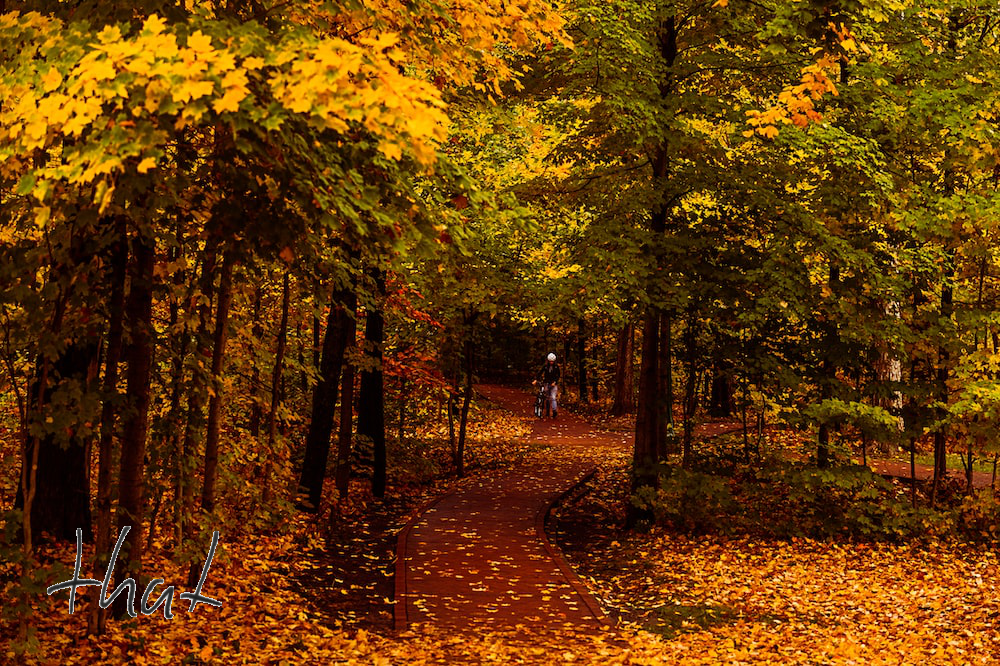

In [ ]:
data = check[1]
print(data)
data[0].show()
# format of bounding box is i j w h, where i,j are top left coordinate of rectangle with width w and height h

## make subroutine for PRINTED text data generator

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
def generatePrintedImages(dest_path, font_ttf_path, texts):
  """
    dest_path: where you want to save images and the csv file
    texts: a list of elements, where each element is a "sentence" or sequence of words (at least 1 word)
  """
  os.makedirs(dest_path, exist_ok=True)
  # TODO: make a dataframe
  # generate a unique filename for every "text" and update dataframe
  # columns: filename words
  # https://www.geeksforgeeks.org/how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-pandas/
  df = pd.DataFrame(columns=['filename', 'words'], index=list(range(len(texts))))
  for i, text in enumerate(texts):
    for font_size in [15,20,25,40]:
      img_file_name = f"printed img {i}-{font_size}.jpg"
      df.loc[i] = [img_file_name, text]
      # generate image (try PIL.image) and exporpt to dest_path
      # try generating images of various font sizes (like maybe 3-5) and update dataframe
      # see PIL ImageDraw to generate printed text or anything else that work
      font = ImageFont.truetype(font_ttf_path,font_size)
      text_width, text_height = font.getsize(text) # get MINIMUM SIZE NEEDED
      # image = Image.new("RGBA", (text_width, text_height), (255,255,255,0)) # transparent background
      # image = Image.new("RGBA", (text_width, text_height), (255,255,255,255)) # white background
      image = Image.new("RGB", (text_width, text_height), (255,255,255))
      draw = ImageDraw.Draw(image)
      x,y = 0,0
      # color = (0,0,0,255) # black in rgba
      color = (0,0,0) # black in rgb
      draw.text((x,y), text, fill=color, font=font)
      
      # out = image
      out = image
      # out.show() # SHOW THE IMAGES
      out.save(os.path.join(dest_path, img_file_name))
    
  # export dataframe as csv to same path
  # print(df.to_string())
  df.to_csv(os.path.join(dest_path, "labels.csv"))

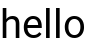

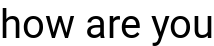

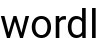

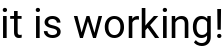

In [ ]:
generatePrintedImages("./sample_printed_database", "./fonts/Roboto-Regular.ttf", ["hello","how are you", "wordl", "it is working!"])

## Test CustomDataset

In [ ]:
texts = [
    "hello how are you", "word", "a word", "charlie", "john doe", "this is a quick test", "who cares",
    "will this work?", "it should work", "if it does not work", "then who cares"
]
# increase frequency to make it evenly distributed with handwritten
texts = texts*1000
generatePrintedImages("./printed_database", "./fonts/Roboto-Regular.ttf", texts)
b = TextDataset("./printed_database","printed_database/labels.csv")
len(b)

11000

In [ ]:
# check = CustomDataset("sample images",b, a, "texttype", random=False)
# check = CustomDataset("sample images",b, a, "text", random=False)
# check = CustomDataset("sample images",b, a, "texttype", random=True)
check = CustomDataset("sample images", b, a, "text", random=True)
print(check)
print(len(check))

['sample images/img2.jpg', 'sample images/img1.jpg']
2


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x666 at 0x7FF0E08E4F10>, '138 225 310 46 hello how are you %% 139 91 144 79 and')


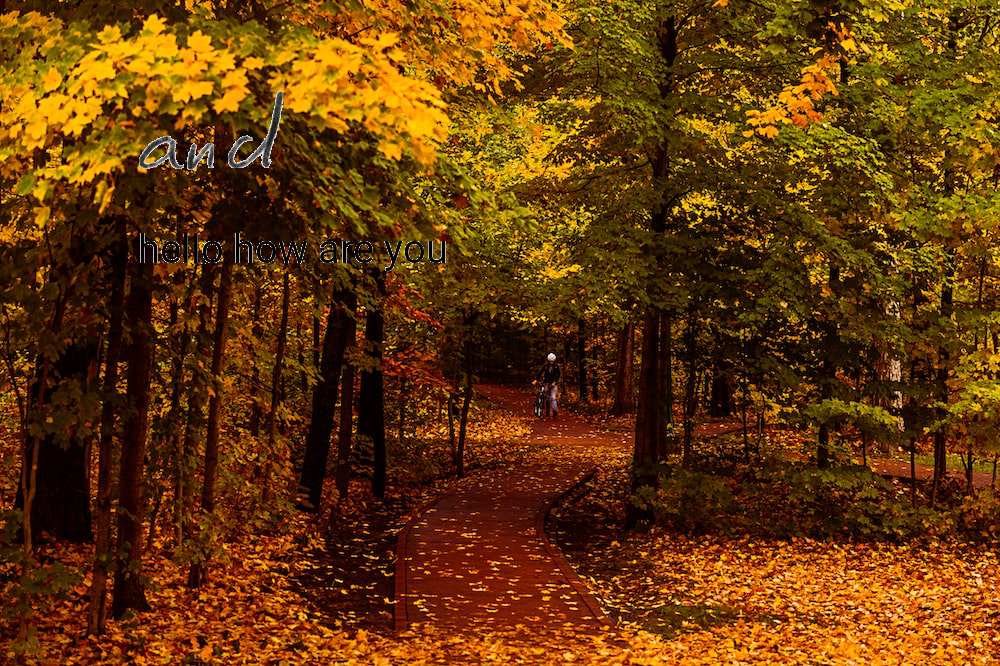

In [ ]:
data = check[1]
print(data)
data[0].show()
# format of bounding box is i j w h, where i,j are top left coordinate of rectangle with width w and height h